In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## IMPORTING AND SORTING THE DATA

WE HAVE CHOSEN ICECUBE 2008-18 DATA FOR THIS STUDY


THE ICE CUBE DATA SET HAS 1134450 NEUTRINO EVENTS


We select neutrino events with Energy >= 100TeV = 10^5 GeV

i.e log10(E/GeV) > 5


There are 192107 such neutrino events in this data

The ms pulsars are taken from the ATNF Catalogue

There are 441 pulsars (as of May 2022 when the study started)

All the pulsars lie in the declination range of -87 to +87 degrees

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]

#icdata = icdata.sort_values('log10(E/GeV)')
#icdata = icdata.reset_index()
#icdata = icdata.drop('index', axis=1)
icdata2 = icdata[icdata['log10(E/GeV)'] > 5]
icdata2 = icdata2.reset_index()
icdata2 = icdata2.drop('index', axis=1)
icdata2

#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [3]:
icdata2

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
1,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
2,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
3,54562.42794822,5.73,0.53,310.767,-25.374,128.245,64.650
4,54562.43975209,5.38,0.64,147.017,-22.059,296.282,67.903
...,...,...,...,...,...,...,...
192102,58307.86622128,5.05,0.31,283.724,-29.301,44.569,60.727
192103,58307.87487966,5.04,0.24,301.335,-69.169,29.895,20.890
192104,58307.88476760,5.09,0.36,6.179,-68.551,328.904,21.560
192105,58307.92028692,5.23,0.66,17.387,-34.366,330.510,55.740


In [4]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1853-0008g,33.014,-0.453,283.30,-0.13,0.00282,354.609929,4.554
1,J1625-0021,13.890,31.827,246.2931579,-0.358044,0.0028336138772234,352.90623328676,0.951
2,J1852-0044g,32.395,-0.560,283.11,-0.73,0.00241,414.937759,4.492
3,J1835-0114,29.990,3.007,278.841325,-1.242669,0.005116387644239,195.4503977286,3.452
4,J1901-0125,32.817,-2.902,285.39083,-1.42472,0.00279,358.422939,2.360
...,...,...,...,...,...,...,...,...
436,J1944+0907,47.160,-7.357,296.03887491,9.12306353,0.005185201908798642,192.8565208431179,1.218
437,J0023+0923,111.383,-52.849,5.82032291,9.38996121,0.003050203104754390,327.8470205611185,1.818
438,B1855+09,42.290,3.060,284.401626217,9.721442158,0.005362100549682627,186.4940783438289,1.200
439,J2234+0944,76.280,-40.438,338.69522573,9.74172845,0.003627027895734199,275.7078326240928,1.587


In [84]:
msr = pd.DataFrame(mspdata['RAJD'], mspdata['DECJD'])

In [85]:
msr

,RAJD
DECJD,
-0.13,NaN
-0.358044,NaN
-0.73,NaN
-1.242669,NaN
-1.42472,NaN
...,...
9.12306353,NaN
9.38996121,NaN
9.721442158,NaN


In [5]:
max(mspdata['P0'])

'0.0098613486703673'

In [90]:
msr = pd.DataFrame([msra,msdec]).T

In [92]:
msr.to_csv('msp.txt', sep=',')

In [93]:
icr = pd.DataFrame([icra,icdec]).T

In [95]:
icr.to_csv('icr.txt', sep=',')

In [6]:
#icdata2 = nu_10gev(import_icdata())
#mspdata = import_psrdata()
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1

In [7]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))

In [8]:
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1

In [9]:
def angfinder(b):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
            
        
    return ang

pool = mul.Pool()
op_async = pool.map_async(angfinder, range(0,p))
aang = op_async.get()
op_async = []
pool = []

In [201]:
def n_ij(i):
    arr = []
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]

        if ang != -1:
            if ang < 20:
                arr.append([icra[j], icdec[j], icang[j]])
    return arr


In [ ]:
os.getcwd()

In [ ]:

def nn():
    pool = mul.Pool()
    op_async = pool.map_async(n_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si

nnearp = nn()

In [106]:
f = open('nnearp.txt', 'w')
f.write('msra, msdec, nura, nudec, angerr, angwithpulsar\n')
for i in range(len(nnearp)):
    f.write(f"PULSAR {i} : ({msra[i],msdec[i]})\n")
    for j in nnearp[i]:
        f.write(str(j).replace('[', '').replace(']', '') + '\n')
f.close()
#nnearp = []

In [104]:
f.close()

In [114]:
msdec[0]

-0.13

In [203]:
(msra[57],msdec[57])

(267.02, -24.77917)

In [202]:
f = open('nu_near_p57.txt', 'w')
n0 = n_ij(57)
for j in n0:
    f.write(str(j).replace('[', '').replace(']', '') + '\n')
    
f.close()

we only select those neutrino events, whose angular distance  is within $20^{\circ}$ of a MSP.  For a dataset of $N$ events, if $n_s$ signal events are attributed to a millisecond pulsar, the probability density of an individual event $i$ is given by:
\begin{equation}
P_i = \frac{n_s}{N} S_i + (1-\frac{n_s}{N}) B_i,
%\label{eq1}
\end{equation}
where $S_i$ and $B_i$ represent the signal and background pdfs, respectively.
The likelihood function ($\mathcal{L}$) of the entire dataset, obtained from the product of each individual PDF can be written as 
\begin{equation}
\mathcal{L} (n_s) = \prod_{i=1}^N P_i,
\end{equation}
where $P_i$ is the same as in eq1 above. The signal PDF is given by:
\begin{equation}
\large
S_i = \frac{1}{2\pi\sigma_i^2}e^{\frac{-(|\theta_i-\theta_s|)^2}{2\sigma_i^2}}
\end{equation}
where $|\theta_i-\theta_s|$ is the angular distance between the  MSP and the neutrino, whereas $\sigma_i$ is the angular uncertainty in the neutrino position.
The background PDF is determined from the average number of events per solid angle  within a declination of $\pm 3^{\circ}$ after averaging over RA. We do not incorporate  the energy information, since the pubic IceCube catalog only contains the energy of the reconstructed muon. The detection statistic used to ascertain the presence of a signal is given by:
\begin{equation}
TS (n_s) = 2 \log \frac{\mathcal{L} (n_s)}{\mathcal{L} (0)}
\end{equation}
 If the null hypothesis is true, $TS (n_s)$ obeys the $\chi^2$ distribution for one degree of freedom. We calculated $TS (n_s)$ for all MSPs in the  catalog.

### FOR $\nu_i$ and $p_j$ and  N = len(icdata2) = Total no.of $\nu$ samples
### ns[i] = no.of $\nu$ events with angles $<= 20 \deg$ with $psr_i$
### $S_i = \frac{1}{2\pi\sigma_i^2}e^{\frac{-(|\theta_i-\theta_s|)^2}{2\sigma_i^2}}$
### $|\theta_i-\theta_s|$ = aang[i][s]
### $\sigma_i$ = icang[i]           and                  sg =      $\sigma_i^2$
###

In [132]:
#N != len(icdata2)

Ns = []
for i in aang:
    count = 0
    for j in i:
        if j != -1:
            count += 1
    Ns.append(count)
Ns = np.array(Ns)
    

Ns = np.sum(ns)//2

In [225]:

#S_ij for ith neutrino and jth pulsar IS WRONG
#EDIT 04102022 - 11.28 - S_ij is for i^th pulsar and j^th neutrino and summed over all NEUTRINOS
def S_ij(i):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
                                                 #OR
    arr = []
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]
        if ang != -1:
            if ang < 20:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        #else:
            #arr.append(0)
        #return -1
    
    return arr

'''
def S_ij(i):
    arr = []
    
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]
        if ang != -1:
            if ang < 20:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.deg2rad(icra[j]) * np.exp(-ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        else:
            arr.append(0)
        #return -1
    
    return np.sum(arr)/np.deg2rad(np.sum(icra))
'''
def sij():
    pool = mul.Pool()
    op_async = pool.map_async(S_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si
#for i in range(len(si)):

#S = Si()

### S stores $S_i$ values for all pulsars

In [226]:
S = np.array(sij()) 

/tmp/ipykernel_5138/1415125087.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  S = np.array(sij())


In [224]:
S[0]

array([0., 0., 0., ..., 0., 0., 0.])

2103.12813

For each sample, given the Dec δi of an event, the background PDF is determined by the relative number of
events in δi ± $3^◦$ divided by the solid angle.

so calculate total no of events within delta +/- 3
and then divide by 2 pi (sin[delta+3]-sin[delta-3])

you can choose all events
withiin delta +/- 3


In [13]:
def bg(i):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<6)
    #calculating solid angle with 3deg
    sang = 2 * np.pi * (np.sin(np.deg2rad(msdec[i] + 6)) - np.sin(np.deg2rad(msdec[i] - 6)))
    return count/sang

def Bi():
    pool = mul.Pool()
    op_async = pool.map_async(bg, range(0,p))
    return op_async.get()

B = np.array(Bi())

### B stores $B_i$ values for all pulsars

In [14]:
for i in range(len(S)):
    if S[i] == max(S):
        print(i)

176


In [15]:
max(S)

81013.82532461955

In [16]:
min(S)

1.6047852132712384e-301

In [17]:
max(B)

49943.391196415156

In [18]:
min(B)

1.1695157219219698

### For $a^{th}$ pulsar

                                               
### $P_i[a] = \dfrac{ns}{N} S[a] + \left(1 - \dfrac{ns}{N}\right)B[a]$     where ns is a scalar number specified manually in
### $\mathcal{L}(ns) = np.product(P_i(ns, N, S, B))$ and N = = no.of $\nu$ events with angles $<= 20 \deg$ with $psr_a$

'\nimport numpy as np\nimport matplotlib.pylab as plt\nfrom math import pi\nfrom scipy.optimize import minimize\ndata=np.genfromtxt("nnearp.txt", delimiter=\',\',names=True)\n\n\nnura=data[\'nura\'] #neutrino RA\nnudec=data[\'nudec\'] #neutrino DEC\nangerr=data[\'angerr\'] # error in neutrino position\nra=283.3 #pulsar RA\ndec=-0.13 # pulsar DEC\ncang=np.sin(dec*pi/180.0)*np.sin(nudec*pi/180.0)+ np.cos(dec*pi/180.0)*np.cos(nudec*pi/180.0)*np.cos((ra-nura)*pi/180.0) \nang=(180.0/pi)*np.arccos(cang) # angle between pulsar and neutrino in degrees\nangerrrad=angerr*pi/180.0 # angle between pulsar and neutrino in radins\nN=len(nura) # total no of neutrinos  used for analysis\nbkgct=np.count_nonzero(np.abs(nudec-dec)<3) # total no of bkgd neutrinos within 3 degrees\nBi=bkgct/(2*pi*(np.sin((180.0/pi)*(dec+3))- np.sin((180.0/pi)*(dec-3))))\nSi=np.exp(-0.5*(ang/angerr)**2)/(2*pi*angerrrad*angerrrad)\n\n\n# the function rtruns TS(ns) in Zhou paper\ndef L(x):\n    TS=np.log(x*Si/N+(1-x/N)*Bi)-np.

In [21]:
#RETURNS ALL THE PROBABILITIES FOR

def Pr(ns, Ns, S, B):
    nsN = ns/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

In [204]:
s0 = S_ij(57)
s0

41916.43101728077

In [205]:
b0 = bg(57)
b0
n0 = Ns[57]

In [206]:
p00 = Pr(0, n0, s0, b0)
a = []
for i in range(1000):
    a.append(Pr(i, n0, s0, b0)/p00)

a.index(max(a))
#p02 = Pr(2, N, s0, b0)
#p02/p00

999

In [33]:
def Ls(ns1, N,S, B):
    return np.prod(Pr(ns1, N,S, B))

def L_n(S, B, N, ns):
    L = np.ones(len(ns))
    for i in range(0, len(l)):
        for j in range(len(l[i])):
            L[i] *= l[i][j]
    return L
L = L_n(S, B, N, 0)


In [158]:
TS = lambda i, x: np.log(Pr(x,  Ns[i], S[i], B[i])/Pr(0, Ns[0], S[0], B[0]))

In [159]:
B[1]

101.25481653481943

In [160]:
f(1,0)

1.072598827058726

def TS(i, S, B, N):
    ts =2 * np.log(np.product(Pr(i, N, S, B)/Pr(0, N, S, B)))
    return ts
ts = TS(1000, S, B, N)

In [167]:
def TSmax(i):
    #returns the TSmax for i^th GRB
    a = []
    for j in range(345):
        a.append(TS(i,j))
         
    init_guess = a.index(max(a))
    nll = lambda x: -TS(i,x)
    soln = minimize(nll, 1000 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns

ns = []
for i in range(p):
    ns.append(TSmax(i))

/tmp/ipykernel_5138/101144605.py:1: RuntimeWarning: invalid value encountered in log
  TS = lambda i, x: np.log(Pr(x,  Ns[i], S[i], B[i])/Pr(0, Ns[0], S[0], B[0]))


In [168]:
ns

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 999.99993622884,
 1000.0000420108059,
 999.9999558575676,
 1000.0,
 1000.0,
 1000.0,
 1000.0000373034641,
 1000.0000738963859,
 999.9999591438251,
 999.9999748645706,
 999.9999531042166,
 1000.0000119015814,
 1000.0,
 999.9999807265435,
 1000.0,
 1000.0,
 1000.0000297539534,
 999.9999839239833,
 0.0,
 1000.0,
 1000.0,
 1000.0000321520333,
 1000.0,
 1000.0,
 1000.0,
 999.9999676703312,
 1000.0000324184866,
 999.9999653610691,
 999.9999702460466,
 999.9999793054592,
 999.999979394277,
 999.999970423682,
 1000.0,
 1000.0000131450302,
 1000.0000142108435,
 1000.0000141220256,
 1000.0000136779369,
 1000.0000142108435,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.000013944

In [123]:
TSmax(0)

0.0

In [ ]:
TS(TSmax(0), S[0], B[0], N)

In [124]:
[msra[0], msdec[0]]

[283.3, -0.13]

def TSmax(i):
    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(x, S[i], B[i], N)
    a = []
    for j in range(1000):
        a.append(nll(j))
         
    init_guess = a.index(min(a))
    soln = minimize(nll, init_guess, bounds=((0,None),))
    ns = float(soln.x)
    return ns

NS = []
for i in range(p):
    NS.append(TSmax(i))

In [76]:
len(ns)

441

In [188]:
ns

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 999.99993622884,
 1000.0000420108059,
 999.9999558575676,
 1000.0,
 1000.0,
 1000.0,
 1000.0000373034641,
 1000.0000738963859,
 999.9999591438251,
 999.9999748645706,
 999.9999531042166,
 1000.0000119015814,
 1000.0,
 999.9999807265435,
 1000.0,
 1000.0,
 1000.0000297539534,
 999.9999839239833,
 0.0,
 1000.0,
 1000.0,
 1000.0000321520333,
 1000.0,
 1000.0,
 1000.0,
 999.9999676703312,
 1000.0000324184866,
 999.9999653610691,
 999.9999702460466,
 999.9999793054592,
 999.999979394277,
 999.999970423682,
 1000.0,
 1000.0000131450302,
 1000.0000142108435,
 1000.0000141220256,
 1000.0000136779369,
 1000.0000142108435,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.000013944

In [187]:
c = 0
for i in ns:
    if i != 0:
        c +=1
c

397

In [125]:
tns = np.array([TS(ns[i], S[i], B[i], N) for i in range(p)])

In [193]:
ns

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 999.99993622884,
 1000.0000420108059,
 999.9999558575676,
 1000.0,
 1000.0,
 1000.0,
 1000.0000373034641,
 1000.0000738963859,
 999.9999591438251,
 999.9999748645706,
 999.9999531042166,
 1000.0000119015814,
 1000.0,
 999.9999807265435,
 1000.0,
 1000.0,
 1000.0000297539534,
 999.9999839239833,
 0.0,
 1000.0,
 1000.0,
 1000.0000321520333,
 1000.0,
 1000.0,
 1000.0,
 999.9999676703312,
 1000.0000324184866,
 999.9999653610691,
 999.9999702460466,
 999.9999793054592,
 999.999979394277,
 999.999970423682,
 1000.0,
 1000.0000131450302,
 1000.0000142108435,
 1000.0000141220256,
 1000.0000136779369,
 1000.0000142108435,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.0000139443902,
 1000.000013944

In [186]:
c = 0
for i in ns:
    if i != 0:
        c+=1
c

397

We use the same unbinned likelihood method as in ~\cite{Hooper,Kamionkowski,LuoZhang} which was first proposed in ~\cite{Montaruli10}. Similar to ~\cite{LuoZhang}, we only select those neutrino events, whose angular distance  is within $20^{\circ}$ of a MSP.  For a dataset of $N$ events, if $n_s$ signal events are attributed to a millisecond pulsar, the probability density of an individual event $i$ is given by:
\begin{equation}
P_i = \frac{n_s}{N} S_i + (1-\frac{n_s}{N}) B_i,
%\label{eq1}
\end{equation}
where $S_i$ and $B_i$ represent the signal and background pdfs, respectively.
The likelihood function ($\mathcal{L}$) of the entire dataset, obtained from the product of each individual PDF can be written as 
\begin{equation}
\mathcal{L} (n_s) = \prod_{i=1}^N P_i,
\end{equation}
where $P_i$ is the same as in Eq.~\ref{eq1}. The signal PDF is given by
\begin{equation}
S_i = \frac{1}{2\pi\sigma_i^2}e^{-(|\theta_i-\theta_s|)^2/2\sigma_i^2}
\end{equation}
where $|\theta_i-\theta_s|$ is the angular distance between the  MSP and the neutrino, whereas $\sigma_i$ is the angular uncertainty in the neutrino position.
The background PDF is determined from the average number of events per solid angle  within a declination of $\pm 3^{\circ}$ after averaging over RA. We do not incorporate  the energy information, since the pubic IceCube catalog only contains the energy of the reconstructed muon. The detection statistic used to ascertain the presence of a signal is given by:
\begin{equation}
TS (n_s) = 2 \log \frac{\mathcal{L} (n_s)}{\mathcal{L} (0)}
\end{equation}
 If the null hypothesis is true, $TS (n_s)$ obeys the $\chi^2$ distribution for one degree of freedom. We calculated $TS (n_s)$ for all MSPs in the  catalog.

def Ls(ns1, N,S, B):
    return np.prod(Pr(ns1, N,S, B))

def TS(ns, S, B, N):
    ts = []
    for j in range(p):
        for i in ns:
            temp = []          
            temp.append(2 * np.log10(Pr(i, N, S[j], B[j])/Pr(0, N, S[j], B[j])))
        ts.append(temp)
    return ts
ts = TS(list(range(1000)), S, B, N)

In [195]:
max(ns)

170579.13902947362

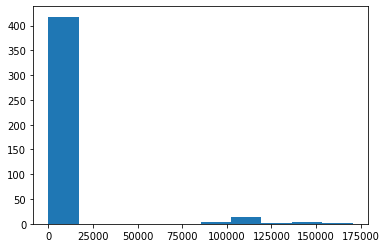

In [194]:
plt.figure()
plt.hist(ns)
plt.show()

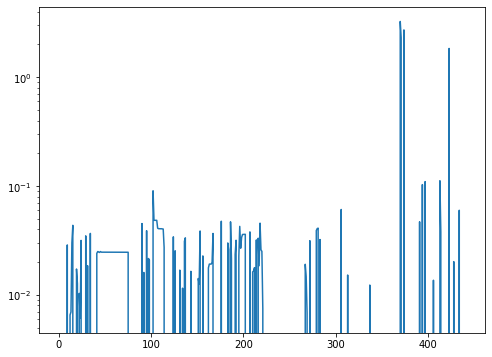

In [171]:
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.plot(np.sqrt(tns))
plt.show()

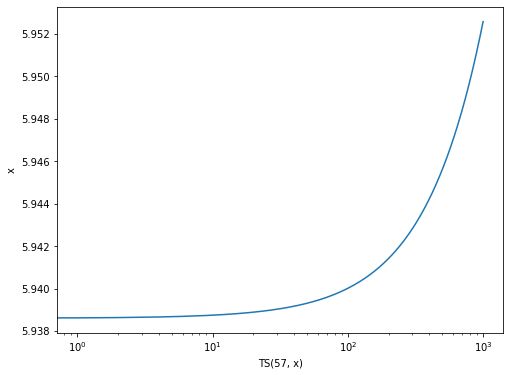

In [200]:
i = 57
x = np.array(range(0, 1000))
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.plot(x, TS(i, x))
plt.ylabel('x')
plt.xlabel(f'TS({i}, x)')
plt.savefig(f"TS({i}).jpg")
plt.show()


In [212]:
len(Si)

12096

In [213]:
Ns[57]

12096